In [4]:
!pip install SimpleITK
!pip install tqdm
!pip install nibabel

In [2]:
import SimpleITK as sitk
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pydicom
from tqdm import tqdm
import nibabel as nib
import shutil
import math


In [3]:
# 1. 경로 설정
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection'
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
IMAGE_DIR = os.path.join(BASE_DIR, 'train_images')
SEG_DIR = os.path.join(BASE_DIR, 'segmentations')
BBOX_CSV = os.path.join(BASE_DIR, 'train_bounding_boxes.csv')
CONV_DIR = os.path.join(BASE_DIR, 'converted_images')
PROC_DIR = os.path.join(BASE_DIR, 'processed_masks')
train_df = pd.read_csv(TRAIN_CSV)
df_bbox = pd.read_csv(BBOX_CSV)

# 추가된 summary 경로
SUMMARY_DIR = os.path.join(BASE_DIR, 'patient_summaries') 
GOLDEN_DATA_DIR = os.path.join(BASE_DIR, 'gold_dataset')

FILTERED_TRAIN_CSV = os.path.join(BASE_DIR, 'filtered_train.csv')
FILTERED_BBOX_CSV = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv')

## Bounding box 환자별 시각화

In [14]:
def save_all_patient_summaries(bbox_df, train_img_dir, psum_dir):
    """
    환자별 골절 슬라이스 요약본을 생성하여 BASE_DIR/patient_summaries 폴더에 직접 저장합니다.
    """
    # 저장할 폴더가 없으면 생성
    if not os.path.exists(psum_dir):
        os.makedirs(psum_dir)
        print(f"✅ 폴더 생성됨: {psum_dir}")

    # 박스 정보가 있는 환자만 추출
    patient_ids = bbox_df['StudyInstanceUID'].unique()

    print(f"🖼️ 총 {len(patient_ids)}명의 환자 요약본 생성을 시작합니다.")

    for patient_id in tqdm(patient_ids):
        # 해당 환자 데이터 필터링
        patient_boxes = bbox_df[bbox_df['StudyInstanceUID'] == patient_id]
        slice_nums = sorted(patient_boxes['slice_number'].unique())
        
        num_slices = len(slice_nums)
        if num_slices == 0: continue

        # 그리드 설정 (5열 고정)
        cols = 5
        rows = math.ceil(num_slices / cols)
        
        # 그래프 생성
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
        fig.suptitle(f"Patient: {patient_id} | Fracture Slices: {num_slices}", fontsize=20)
        
        # 서브플롯 배열 평탄화
        if num_slices == 1:
            axes_flat = [axes]
        else:
            axes_flat = axes.flatten()

        for i, slice_num in enumerate(slice_nums):
            ax = axes_flat[i]
            dcm_path = os.path.join(train_img_dir, patient_id, f"{int(slice_num)}.dcm")
            
            if not os.path.exists(dcm_path):
                ax.text(0.5, 0.5, f"Missing: {slice_num}", ha='center')
                ax.axis('off')
                continue

            # DICOM 로드 및 전처리
            ds = pydicom.dcmread(dcm_path)
            img = ds.pixel_array
            
            # HU 변환 및 Bone Window (350, 2700)
            slope = float(getattr(ds, 'RescaleSlope', 1.0))
            intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
            img = img * slope + intercept
            img = np.clip(img, 350 - 1350, 350 + 1350) 

            ax.imshow(img, cmap='gray')
            ax.set_title(f"Slice: {slice_num}", fontsize=12)

            # 박스 그리기
            slice_boxes = patient_boxes[patient_boxes['slice_number'] == slice_num]
            for _, row in slice_boxes.iterrows():
                rect = patches.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                         linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
            
            ax.axis('off')

        # 남은 빈 칸 숨기기
        for j in range(i + 1, len(axes_flat)):
            axes_flat[j].axis('off')

        # 파일 저장 (BASE_DIR/patient_summaries/환자ID_summary.png)
        save_path = os.path.join(psum_dir, f"{patient_id}_summary.png")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(save_path)
        plt.close(fig) # 메모리 해제

    print(f"\n✨ 모든 요약본이 {psum_dir} 에 저장되었습니다.")

# --- 실행 ---
# if __name__ == "__main__":
#     df_bbox = pd.read_csv(BBOX_CSV)
#     save_all_patient_summaries(df_bbox, IMAGE_DIR, SUMMARY_DIR)

✅ 폴더 생성됨: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\patient_summaries
🖼️ 총 235명의 환자 요약본 생성을 시작합니다.


100%|██████████| 235/235 [09:33<00:00,  2.44s/it]


✨ 모든 요약본이 C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\patient_summaries 에 저장되었습니다.


## Dicom -> Nifti 변환 (mask 유 환자들 대상)

In [8]:
def convert_specific_patients(seg_dir, train_img_dir, conv_dir):
    # 1. 저장할 새 폴더 생성
    if not os.path.exists(conv_dir):
        os.makedirs(conv_dir)
        print(f"폴더 생성됨: {conv_dir}")

    # 2. 세그멘테이션 폴더 내 파일 목록 가져오기 (87명)
    # 파일명이 '1.2.826.0.1.3680043.780.nii.gz' 형태라고 가정합니다.
    seg_files = [f for f in os.listdir(seg_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    print(f"총 {len(seg_files)}명의 마스크 보유 환자를 찾았습니다. 변환을 시작합니다.")

    for seg_file in seg_files:
        # 3. 파일명에서 확장자 제거하여 환자 UID 추출
        # .nii.gz 또는 .nii 모두 대응
        patient_uid = seg_file.replace('.nii.gz', '').replace('.nii', '')
        
        # 4. 해당 환자의 DICOM 폴더 경로 설정
        dicom_dir = os.path.join(train_img_dir, patient_uid)
        
        # 5. 저장할 파일 경로 설정
        output_path = os.path.join(conv_dir, f"{patient_uid}_image.nii.gz")

        # 6. DICOM 폴더가 실제로 존재하는지 확인 후 변환
        if os.path.exists(dicom_dir):
            try:
                print(f"[{patient_uid}] 변환 중...")
                
                # DICOM 읽기
                reader = sitk.ImageSeriesReader()
                dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
                reader.SetFileNames(dicom_names)
                image = reader.Execute()
                
                # 방향 교정 (마스크와 축을 맞추기 위해 LAS 고정)
                image = sitk.DICOMOrient(image, 'LAS')
                
                # NIfTI 저장
                sitk.WriteImage(image, output_path)
                
            except Exception as e:
                print(f"❌ {patient_uid} 변환 실패: {e}")
        else:
            print(f"⚠️ 경고: 마스크는 있으나 DICOM 폴더가 없습니다: {dicom_dir}")

    print("\n✅ 모든 작업이 완료되었습니다!")

# if __name__ == "__main__":
#     convert_specific_patients(SEG_DIR, IMAGE_DIR, CONV_DIR)

총 87명의 마스크 보유 환자를 찾았습니다. 변환을 시작합니다.
[1.2.826.0.1.3680043.10633] 변환 중...
[1.2.826.0.1.3680043.10921] 변환 중...
[1.2.826.0.1.3680043.11827] 변환 중...
[1.2.826.0.1.3680043.11988] 변환 중...
[1.2.826.0.1.3680043.12281] 변환 중...
[1.2.826.0.1.3680043.12292] 변환 중...
[1.2.826.0.1.3680043.12833] 변환 중...
[1.2.826.0.1.3680043.1363] 변환 중...
[1.2.826.0.1.3680043.14267] 변환 중...
[1.2.826.0.1.3680043.1480] 변환 중...
[1.2.826.0.1.3680043.15206] 변환 중...
[1.2.826.0.1.3680043.1542] 변환 중...
[1.2.826.0.1.3680043.1573] 변환 중...
[1.2.826.0.1.3680043.16092] 변환 중...
[1.2.826.0.1.3680043.16919] 변환 중...
[1.2.826.0.1.3680043.17481] 변환 중...
[1.2.826.0.1.3680043.17960] 변환 중...
[1.2.826.0.1.3680043.18480] 변환 중...
[1.2.826.0.1.3680043.1868] 변환 중...
[1.2.826.0.1.3680043.18906] 변환 중...
[1.2.826.0.1.3680043.18935] 변환 중...
[1.2.826.0.1.3680043.18968] 변환 중...
[1.2.826.0.1.3680043.19021] 변환 중...
[1.2.826.0.1.3680043.19333] 변환 중...
[1.2.826.0.1.3680043.19388] 변환 중...
[1.2.826.0.1.3680043.20120] 변환 중...
[1.2.826.0.1.3680043.20647] 변환 중.

## nifti -> npy 슬라이스 (mask 유 환자들 대상)

In [31]:
mask_dict = {}

# 1. 저장할 새 폴더 생성
if not os.path.exists(PROC_DIR):
        os.makedirs(PROC_DIR)
        print(f"폴더 생성됨: {PROC_DIR}")

for patient_id in os.listdir(PROC_DIR):
    patient_path = os.path.join(PROC_DIR, patient_id)
    if os.path.isdir(patient_path):
        for npy_file in os.listdir(patient_path):
            slice_num = int(npy_file.replace('.npy', ''))
            # Key: (환자ID, 슬라이스번호), Value: 파일 경로
            mask_dict[(patient_id, slice_num)] = os.path.join(patient_path, npy_file)

폴더 생성됨: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\processed_masks


In [14]:
def process_and_align_fixed(seg_dir, img_dir, output_dir):
    seg_files = [f for f in os.listdir(seg_dir) if f.endswith('.nii.gz') or f.endswith('.nii')]
    
    for seg_file in tqdm(seg_files):
        patient_id = seg_file.replace('.nii.gz', '').replace('.nii', '')
        patient_img_dir = os.path.join(img_dir, patient_id)
        
        if not os.path.exists(patient_img_dir): continue
        
        # [A] DICOM 물리적 정렬 (Z축 기준 내림차순: 머리 -> 가슴 순서)
        dcm_files = [f for f in os.listdir(patient_img_dir) if f.endswith('.dcm')]
        dcm_list = []
        for f in dcm_files:
            ds = pydicom.dcmread(os.path.join(patient_img_dir, f), stop_before_pixels=True)
            dcm_list.append({'z': ds.ImagePositionPatient[2], 'file': f})
        
        # Z값이 큰 것(머리)부터 작은 것(다리) 순서로 정렬
        dcm_list.sort(key=lambda x: x['z'], reverse=True)
        
        # [B] NIfTI 로드
        seg_path = os.path.join(seg_dir, seg_file)
        mask_vol = nib.load(seg_path).get_fdata() 
        
        # [C] 저장 폴더 생성
        patient_save_dir = os.path.join(output_dir, patient_id)
        os.makedirs(patient_save_dir, exist_ok=True)
        
        # [D] 슬라이스별 저장 (역순 로직 포함)
        num_slices = min(mask_vol.shape[2], len(dcm_list))
        
        for s in range(num_slices):
            # 핵심 수정: s번째 DICOM에 대해 NIfTI의 뒤에서부터 (-s-1) 가져옴
            # 0번 DICOM(머리) <-> 마지막 NIfTI 슬라이스(머리) 매칭
            slice_mask = mask_vol[:, :, -s-1] 
            
            # 아까 찾은 정답: 90도 회전 (k=1)
            slice_mask = np.rot90(slice_mask, k=1) 
            
            # 정렬된 DICOM 파일명과 매칭해서 저장
            dcm_filename = dcm_list[s]['file']
            save_filename = dcm_filename.replace('.dcm', '.npy')
            
            np.save(os.path.join(patient_save_dir, save_filename), slice_mask.astype(np.uint8))

    print(f"✅ 정렬 및 분할 완료! 저장 경로: {output_dir}")

# 실행
process_and_align_fixed(SEG_DIR, IMAGE_DIR, PROC_DIR)

100%|██████████| 87/87 [02:54<00:00,  2.01s/it]

✅ 정렬 및 분할 완료! 저장 경로: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\processed_masks


In [8]:
# def process_and_align_fixed(seg_dir, img_dir, output_dir):
#     seg_files = [f for f in os.listdir(seg_dir) if f.endswith('.nii.gz') or f.endswith('.nii')]
    
#     for seg_file in tqdm(seg_files):
#         patient_id = seg_file.replace('.nii.gz', '').replace('.nii', '')
#         patient_img_dir = os.path.join(img_dir, patient_id)
        
#         if not os.path.exists(patient_img_dir): continue
        
#         # [A] DICOM 정렬: Z값 기준 내림차순 (머리 -> 발 순서)
#         dcm_files = [f for f in os.listdir(patient_img_dir) if f.endswith('.dcm')]
#         dcm_list = []
#         for f in dcm_files:
#             ds = pydicom.dcmread(os.path.join(patient_img_dir, f), stop_before_pixels=True)
#             dcm_list.append({'z': ds.ImagePositionPatient[2], 'file': f})
        
#         # Z가 큰 것(Superior)부터 정렬
#         dcm_list.sort(key=lambda x: x['z'], reverse=True)
        
#         # [B] NIfTI 로드 (LAS 기준: index 0은 발, index -1은 머리)
#         seg_path = os.path.join(seg_dir, seg_file)
#         mask_vol = nib.load(seg_path).get_fdata() 
        
#         # [C] 저장 폴더 생성
#         patient_save_dir = os.path.join(output_dir, patient_id)
#         os.makedirs(patient_save_dir, exist_ok=True)
        
#         # [D] 슬라이스 매칭 및 저장
#         # dcm_list[0] (가장 위쪽 DICOM) <-> mask_vol[:,:,-1] (가장 위쪽 Mask)
#         num_slices = min(mask_vol.shape[2], len(dcm_list))
        
#         for s in range(num_slices):
#             # NIfTI의 뒤에서부터 가져옴 (머리 -> 발 순서로 추출)
#             slice_mask = mask_vol[:, :, -s-1] 
            
#             # ❗ 중요: LAS -> DICOM 좌표계 변환을 위한 회전 및 대칭 조정
#             # 90도 회전 후 좌우 반전이 필요할 수 있습니다 (데이터 확인 결과에 따라 k값 조정)
#             slice_mask = np.rot90(slice_mask, k=1) 
#             # 만약 좌우가 뒤집혀 보인다면 아래 주석을 해제하세요.
#             # slice_mask = np.fliplr(slice_mask) 
            
#             # 정렬된 DICOM 파일명(머리순) 그대로 사용하여 npy 저장
#             dcm_filename = dcm_list[s]['file']
#             save_filename = dcm_filename.replace('.dcm', '.npy')
            
#             np.save(os.path.join(patient_save_dir, save_filename), slice_mask.astype(np.uint8))

#     print(f"✅ 역순 정렬 및 저장 완료! 경로: {output_dir}")

# # 실행
# process_and_align_fixed(SEG_DIR, IMAGE_DIR, PROC_DIR)

100%|██████████| 87/87 [03:17<00:00,  2.27s/it]

✅ 역순 정렬 및 저장 완료! 경로: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\processed_masks


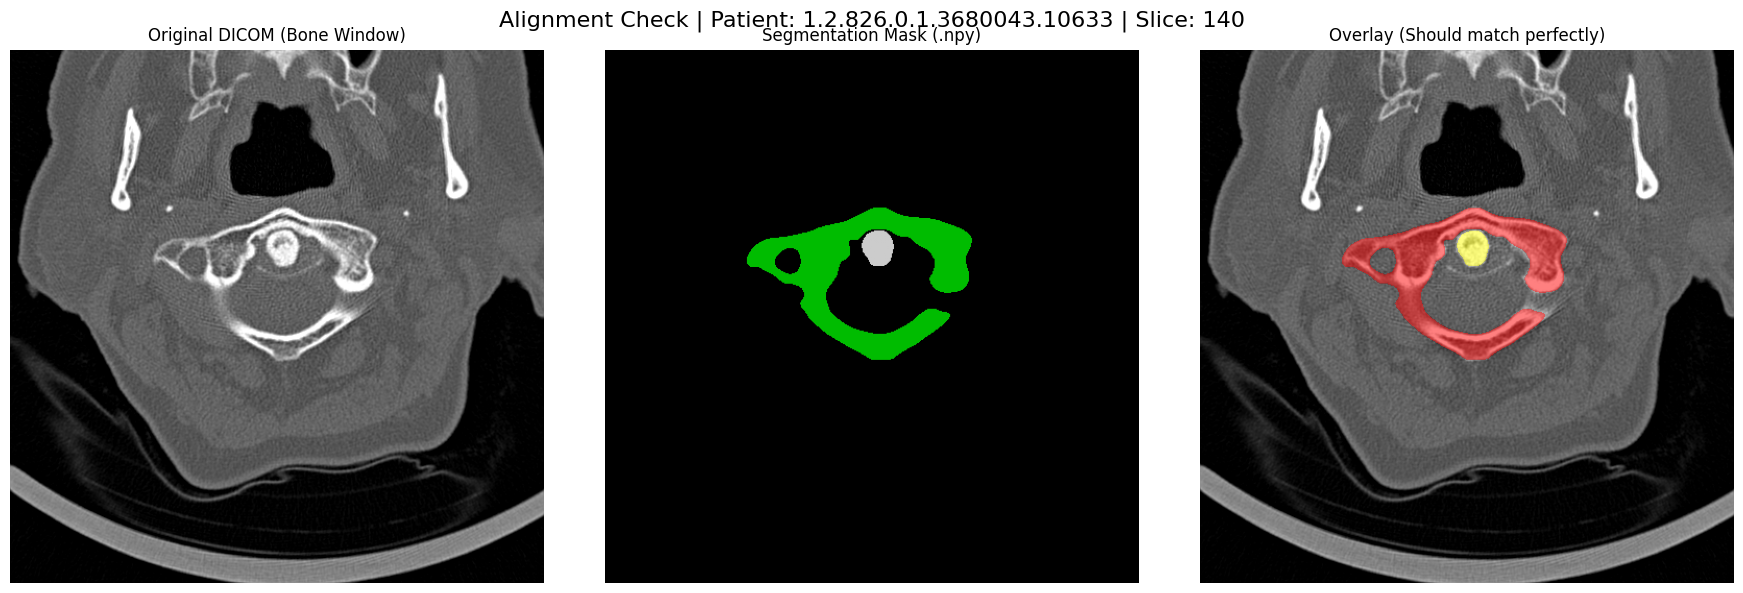

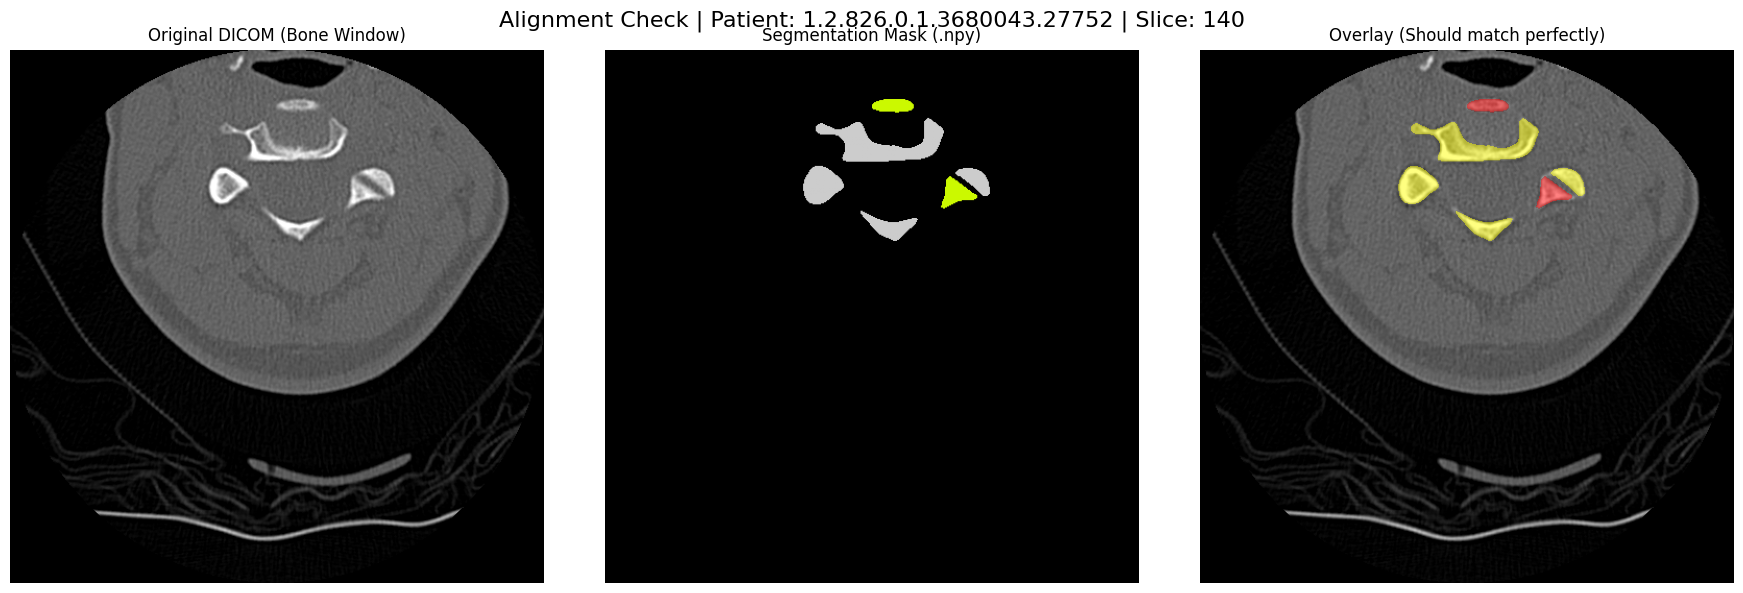

In [10]:
def check_mask_alignment(patient_id, slice_num, base_dir):
    # 1. 경로 설정 (사용자 구조 반영)
    dcm_path = os.path.join(base_dir, 'train_images', patient_id, f"{slice_num}.dcm")
    npy_path = os.path.join(base_dir, 'processed_masks', patient_id, f"{slice_num}.npy")
    
    if not os.path.exists(dcm_path):
        print(f"❌ DICOM 파일을 찾을 수 없습니다: {dcm_path}")
        return
    if not os.path.exists(npy_path):
        print(f"❌ .npy 마스크 파일을 찾을 수 없습니다: {npy_path}")
        return

    # 2. DICOM 로드 및 전처리
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array
    
    # HU 변환
    slope = float(ds.RescaleSlope) if 'RescaleSlope' in ds else 1.0
    intercept = float(ds.RescaleIntercept) if 'RescaleIntercept' in ds else 0.0
    img = img * slope + intercept
    
    # Bone Windowing (WW=2700, WC=350)
    img = np.clip(img, 350 - 1350, 350 + 1350)

    # 3. .npy 마스크 로드
    mask = np.load(npy_path)

    # 4. 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Alignment Check | Patient: {patient_id} | Slice: {slice_num}", fontsize=16)

    # [좌] 원본 DICOM
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original DICOM (Bone Window)")
    axes[0].axis('off')

    # [중] .npy 마스크
    # 라벨 0~7이 색상별로 보이게 설정
    axes[1].imshow(mask, cmap='nipy_spectral') 
    axes[1].set_title("Segmentation Mask (.npy)")
    axes[1].axis('off')

    # [우] 오버레이 (가장 중요!)
    axes[2].imshow(img, cmap='gray')
    # 배경(0)은 투명하게, 뼈(1~7)는 색상을 입혀서 겹침
    masked_data = np.ma.masked_where(mask == 0, mask)
    axes[2].imshow(masked_data, cmap='autumn', alpha=0.5) 
    axes[2].set_title("Overlay (Should match perfectly)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
# 실제 있는 환자 ID와 슬라이스 번호로 테스트해보세요.
# 예: '1.2.826.0.1.3680043.10633', 133
check_mask_alignment('1.2.826.0.1.3680043.10633', 140, BASE_DIR)
check_mask_alignment('1.2.826.0.1.3680043.27752', 140, BASE_DIR)

npy slice 방향 확인용

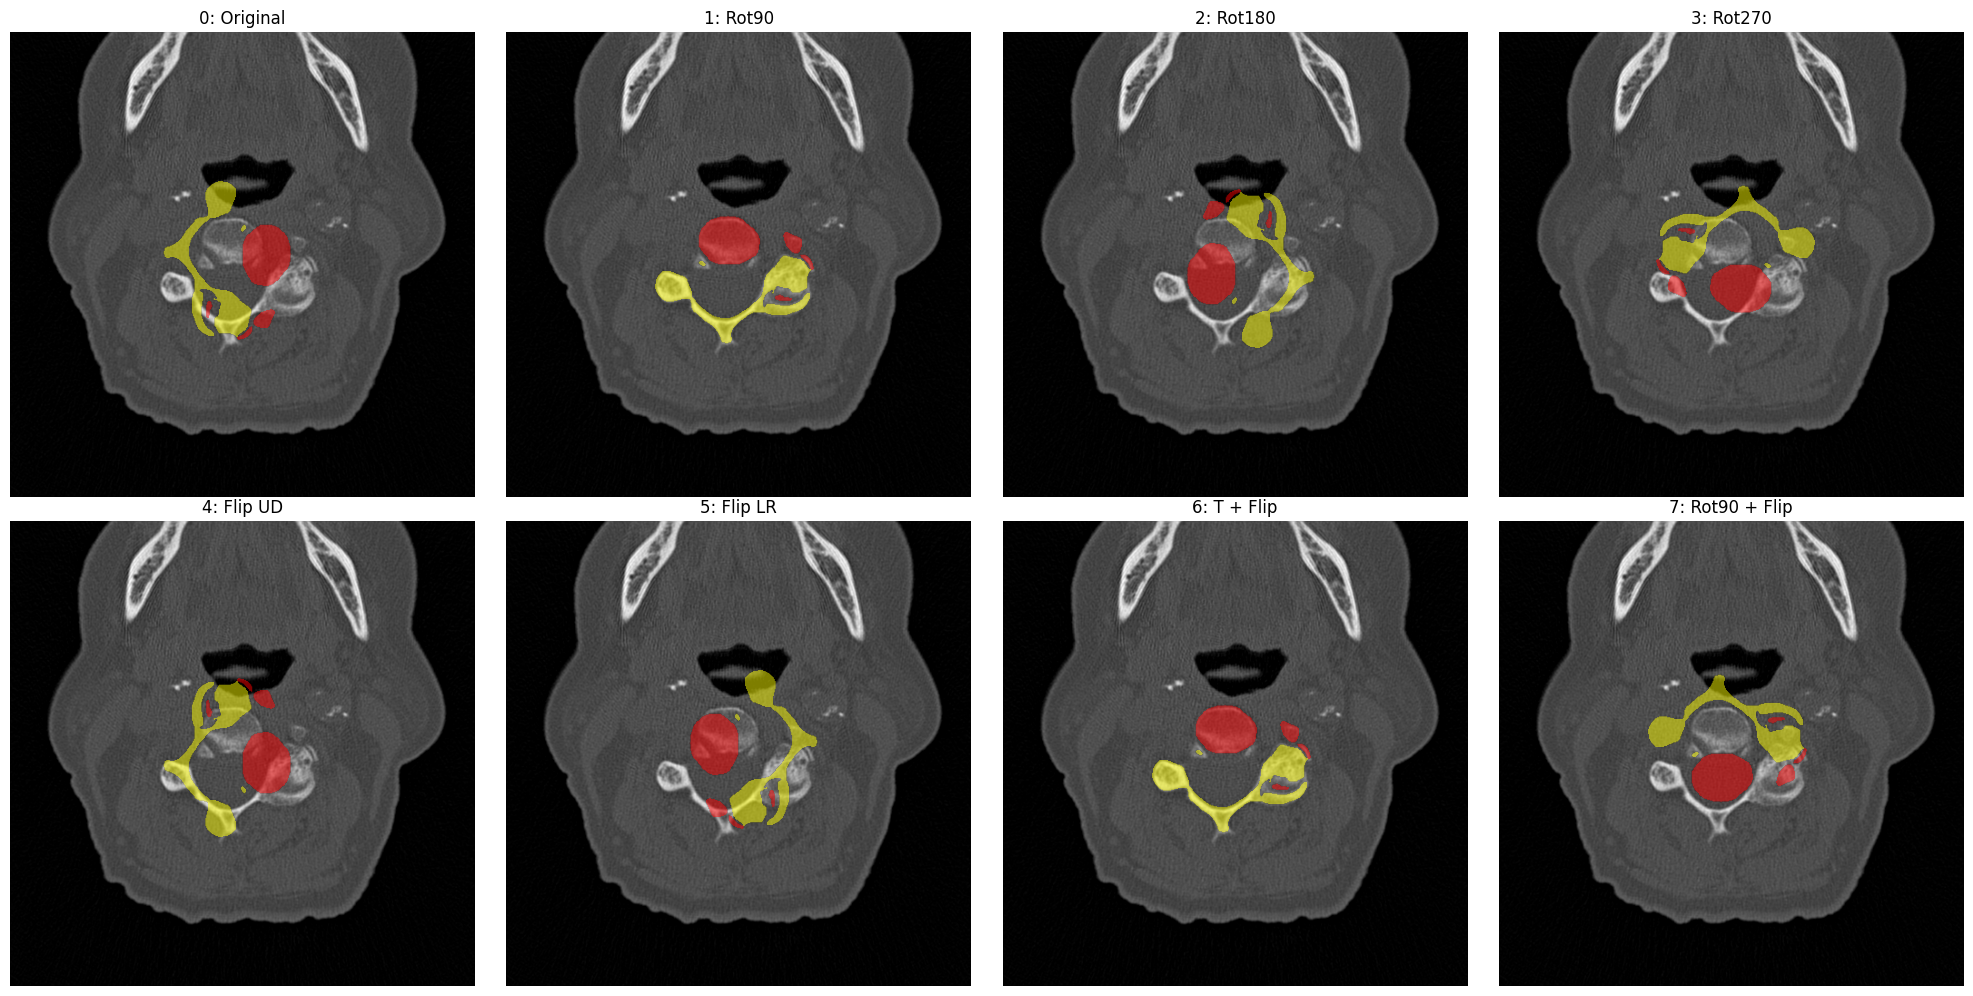

In [ ]:
def diagnostic_alignment(patient_id, base_dir):
    # 1. 경로 설정
    img_dir = os.path.join(base_dir, 'train_images', patient_id)
    seg_path = os.path.join(base_dir, 'segmentations', f"{patient_id}.nii.gz")
    if not os.path.exists(seg_path):
        seg_path = seg_path.replace('.gz', '') # .nii 파일 대응

    # 2. DICOM Z축 정렬 (물리적 순서 고정)
    dcm_files = [f for f in os.listdir(img_dir) if f.endswith('.dcm')]
    dcm_data = []
    for f in dcm_files:
        ds = pydicom.dcmread(os.path.join(img_dir, f), stop_before_pixels=True)
        dcm_data.append({'z': ds.ImagePositionPatient[2], 'file': f})
    
    # Z값 기준 내림차순 정렬 (보통 머리 -> 가슴)
    dcm_data.sort(key=lambda x: x['z'], reverse=True)
    
    # 중간 슬라이스 하나 선택해서 테스트
    mid_idx = len(dcm_data) // 2
    test_dcm = pydicom.dcmread(os.path.join(img_dir, dcm_data[mid_idx]['file']))
    img = test_dcm.pixel_array
    
    # 3. NIfTI 로드
    mask_volume = nib.load(seg_path).get_fdata()
    # NIfTI의 슬라이스도 중간 것을 가져옴
    mask = mask_volume[:, :, mid_idx] 

    # 4. 8가지 변환 조합 생성
    transforms = [
        ("Original", lambda x: x),
        ("Rot90", lambda x: np.rot90(x, k=1)),
        ("Rot180", lambda x: np.rot90(x, k=2)),
        ("Rot270", lambda x: np.rot90(x, k=3)),
        ("Flip UD", lambda x: np.flipud(x)),
        ("Flip LR", lambda x: np.fliplr(x)),
        ("T + Flip", lambda x: np.flipud(x.T)), # 자주 쓰이는 조합
        ("Rot90 + Flip", lambda x: np.flipud(np.rot90(x, k=1)))
    ]

    # 5. 시각화
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, (name, func) in enumerate(transforms):
        t_mask = func(mask)
        axes[i].imshow(img, cmap='gray')
        # 마스크 오버레이
        masked = np.ma.masked_where(t_mask == 0, t_mask)
        axes[i].imshow(masked, cmap='autumn', alpha=0.5)
        axes[i].set_title(f"{i}: {name}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행
diagnostic_alignment('1.2.826.0.1.3680043.10633', BASE_DIR)

## Create Golden dataset

In [9]:
def check_label_overlap():
    # A. Segmentation 마스크가 있는 환자 ID 추출
    seg_files = [f for f in os.listdir(SEG_DIR) if f.endswith('.nii') or f.endswith('.nii.gz')]
    seg_patient_ids = set([f.replace('.nii.gz', '').replace('.nii', '') for f in seg_files])
    
    # B. Bounding Box 정보가 있는 환자 ID 추출 (CSV 파일 읽기)
    bbox_df = pd.read_csv(BBOX_CSV)
    bbox_patient_ids = set(bbox_df['StudyInstanceUID'].unique())
    
    # C. 교집합 및 차집합 계산
    overlap = seg_patient_ids.intersection(bbox_patient_ids)
    only_seg = seg_patient_ids - bbox_patient_ids
    only_bbox = bbox_patient_ids - seg_patient_ids
    
    print(f"📊 --- 데이터 라벨 중복 분석 결과 ---")
    print(f"✅ Mask와 Box가 모두 있는 환자 (Overlap): {len(overlap)}명")
    print(f"💠 Mask만 있는 환자 (Only Seg): {len(only_seg)}명")
    print(f"📦 Box만 있는 환자 (Only Box): {len(only_bbox)}명")
    print(f"--------------------------------------")
    
    return list(overlap)

# 실행
overlap_patients = check_label_overlap()

# 겹치는 환자 ID 중 앞의 5명만 확인
print(f"📍 겹치는 환자 샘플: {overlap_patients[:5]}")

📊 --- 데이터 라벨 중복 분석 결과 ---
✅ Mask와 Box가 모두 있는 환자 (Overlap): 40명
💠 Mask만 있는 환자 (Only Seg): 47명
📦 Box만 있는 환자 (Only Box): 195명
--------------------------------------
📍 겹치는 환자 샘플: ['1.2.826.0.1.3680043.32071', '1.2.826.0.1.3680043.19388', '1.2.826.0.1.3680043.30524', '1.2.826.0.1.3680043.31077', '1.2.826.0.1.3680043.23904']


In [18]:
def create_tiered_dataset_v4():
    # A. 환자 그룹 분류 로직
    seg_files = [f for f in os.listdir(SEG_DIR) if f.endswith('.nii') or f.endswith('.nii.gz')]
    seg_ids = set([f.replace('.nii.gz', '').replace('.nii', '') for f in seg_files])
    
    bbox_df = pd.read_csv(BBOX_CSV)
    bbox_ids = set(bbox_df['StudyInstanceUID'].unique())
    
    groups = {
        '1_mask_and_box': seg_ids.intersection(bbox_ids),
        '2_only_mask': seg_ids - bbox_ids,
        '3_only_box': bbox_ids - seg_ids
    }

    # B. 데이터 복사 및 정리
    for g_name, p_ids in groups.items():
        print(f"\n📂 {g_name} 그룹 생성 중... (대상: {len(p_ids)}명)")
        
        for pid in tqdm(p_ids):
            # 1. train_images (전체 - 폴더 유지)
            src_img = os.path.join(IMAGE_DIR, pid)
            if os.path.exists(src_img):
                target = os.path.join(GOLDEN_DATA_DIR, g_name, 'train_images', pid)
                shutil.copytree(src_img, target, dirs_exist_ok=True)

            # 2. segmentations (Mask 있는 경우만 - 파일만 복사)
            if pid in seg_ids:
                for ext in ['.nii.gz', '.nii']:
                    src_seg = os.path.join(SEG_DIR, pid + ext)
                    if os.path.exists(src_seg):
                        target_dir = os.path.join(GOLDEN_DATA_DIR, g_name, 'segmentations')
                        os.makedirs(target_dir, exist_ok=True)
                        shutil.copy2(src_seg, target_dir)

            # 3. processed_masks (Mask 있는 경우만 - 폴더 유지)
            if pid in seg_ids:
                src_proc = os.path.join(PROC_DIR, pid)
                if os.path.exists(src_proc):
                    target = os.path.join(GOLDEN_DATA_DIR, g_name, 'processed_masks', pid)
                    shutil.copytree(src_proc, target, dirs_exist_ok=True)

            # 4. patient_summaries (Box 있는 경우만 - 파일만 복사)
            if pid in bbox_ids:
                # 파일명이 pid로 시작하는 모든 요약 파일 찾기 (예: pid_summary.csv 등)
                if os.path.exists(SUMMARY_DIR):
                    summary_files = [f for f in os.listdir(SUMMARY_DIR) if f.startswith(pid)]
                    for sf in summary_files:
                        target_dir = os.path.join(GOLDEN_DATA_DIR, g_name, 'patient_summaries')
                        os.makedirs(target_dir, exist_ok=True)
                        shutil.copy2(os.path.join(SUMMARY_DIR, sf), target_dir)

            # 5. converted_images (전체 - 폴더/파일 자동 판별)
            src_conv = os.path.join(CONV_DIR, pid)
            if os.path.exists(src_conv):
                if os.path.isdir(src_conv):
                    target = os.path.join(GOLDEN_DATA_DIR, g_name, 'converted_images', pid)
                    shutil.copytree(src_conv, target, dirs_exist_ok=True)
                else:
                    target_dir = os.path.join(GOLDEN_DATA_DIR, g_name, 'converted_images')
                    os.makedirs(target_dir, exist_ok=True)
                    shutil.copy2(src_conv, target_dir)

    print(f"\n✨ 작업이 완료되었습니다! 경로: {GOLDEN_DATA_DIR}")

create_tiered_dataset_v4()


📂 1_mask_and_box 그룹 생성 중... (대상: 40명)


100%|██████████| 40/40 [00:26<00:00,  1.49it/s]



📂 2_only_mask 그룹 생성 중... (대상: 47명)


100%|██████████| 47/47 [01:55<00:00,  2.46s/it]



📂 3_only_box 그룹 생성 중... (대상: 195명)


100%|██████████| 195/195 [03:31<00:00,  1.08s/it]


✨ 작업이 완료되었습니다! 경로: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\gold_dataset


## CSV 파일 수정

In [5]:
def save_filtered_csv():
    # 데이터 로드
    df_train = pd.read_csv(TRAIN_CSV)
    df_bbox = pd.read_csv(BBOX_CSV)

    # A. 대상 환자 ID 리스트 추출
    # 1. Segmentation 파일이 있는 환자 ID (87명)
    seg_files = [f for f in os.listdir(SEG_DIR) if f.endswith('.nii') or f.endswith('.nii.gz')]
    seg_ids = set([f.replace('.nii.gz', '').replace('.nii', '') for f in seg_files])

    # 2. Bounding Box 정보가 있는 환자 ID (235명)
    bbox_ids = set(df_bbox['StudyInstanceUID'].unique())

    # 3. 전체 대상 환자 합집합 (중복 제외 총 인원)
    target_ids = list(seg_ids.union(bbox_ids))
    print(f"📊 필터링 대상 환자 수: {len(target_ids)}명")

    # B. 데이터 필터링
    # 1. train.csv 필터링
    filtered_train = df_train[df_train['StudyInstanceUID'].isin(target_ids)].reset_index(drop=True)
    
    # 2. train_bounding_boxes.csv 필터링
    filtered_bbox = df_bbox[df_bbox['StudyInstanceUID'].isin(target_ids)].reset_index(drop=True)

    # C. 파일 저장
    filtered_train.to_csv(FILTERED_TRAIN_CSV, index=False)
    filtered_bbox.to_csv(FILTERED_BBOX_CSV, index=False)

    print(f"\n✅ 필터링 완료!")
    print(f"📁 저장된 파일:")
    print(f" - {FILTERED_TRAIN_CSV} (행 수: {len(filtered_train)})")
    print(f" - {FILTERED_BBOX_CSV} (행 수: {len(filtered_bbox)})")

if __name__ == "__main__":
    save_filtered_csv()

📊 필터링 대상 환자 수: 282명

✅ 필터링 완료!
📁 저장된 파일:
 - C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\filtered_train.csv (행 수: 282)
 - C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\filtered_train_bounding_boxes.csv (행 수: 7217)
